# Linking & Exploring Geo-Data

In this practical we're going to expand our understanding of how to use PySAL and GeoPandas as part of an analysis, and of how to implement different types of spatial and non-spatial joins in Python using the tools to-hand.

You'll notice that the number of libraries that we need to do our work is expanding -- gone are the days of just importing Seaborn and Pandas!

In [1]:
import os
import shapely
import zipfile
import numpy as np
import pysal as ps
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
from pysal.contrib.viz import mapping as maps # For maps.plot_choropleth

import random 
random.seed(123456789) # For reproducibility

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

# Make sure output is into notebook
%matplotlib inline

## Loading the Data

Let's start by (re)loading both the AirBnB and the LSOA data, together with the NS-SeC data from last term! This will give us the tools with which to test our understanding of data linking _and_ allow us to do some simple, but hopefully interesting, analyses. To try to reduce confusion, I've provided a way to automate the downloading of the data in the answers:

In [2]:
from zipfile import ZipFile
import urllib
import os

# Create the data dir if it doesn't exist
if os.path.isdir('data') is not True:
    print("Creating 'data' directory...")
    os.mkdir('data')

# Configure the download
url  = 'http://www.reades.com/LDN-LSOAs.zip'
path = os.path.join("data","LDN-LSOAs.zip")

# Download
r    = urllib.urlretrieve(url, path)

# Unzip it into the data folder
z    = ZipFile(path)
m    = z.extractall("data")

# Configure the next download
url  = 'http://www.reades.com/NSSHRP_UNIT_URESPOP.zip'
path = os.path.join("data","NSSHRP_UNIT_URESPOP.zip")

# Download but don't unzip it
r    = urllib.urlretrieve(url, path)

# Configure the next download -- notice 
# that you will need to visit InsideAirBnB
# in order to check that the data hasn't been
# updated from 2016/10/13.
url  = 'http://data.insideairbnb.com/united-kingdom/england/london/2016-10-03/data/listings.csv.gz'
path = os.path.join("data","listings.csv.gz")

# Download but don't unzip it
r    = urllib.urlretrieve(url, path)

### Loading AirBnB Data

Here is all the code to load the AirBnB data into a GeoDataFrame called `sdf` (spatial sample  dataframe):

In [3]:
df       = pd.read_csv(os.path.join('data','listings.csv.gz'))
sample   = df.sample(frac=0.1)
geometry = [Point(xy) for xy in zip(sample.longitude, sample.latitude)]
crs      = {'init': 'epsg:4326'} # What projection is lat/long?
sdf      = gpd.GeoDataFrame(sample, crs=crs, geometry=geometry)
sdf      = sdf.to_crs({'init': 'epsg:27700'}) # Reproject into OSGB

# Check the output
sdf.head(3)[['id','host_id','neighbourhood','price','geometry']]

,id,host_id,neighbourhood,price,geometry
19230,9892621,46599571,Bayswater,$70.00,POINT (526300.7029680212 180985.1766901776)
41511,12852311,41289215,NaN,$27.00,POINT (533456.7811158752 183470.8938045508)
21785,2805238,14350054,LB of Croydon,$43.00,POINT (536781.3083786573 163022.8438414784)


### Loading the LSOA Shapefile

Here is all of the code to load the LDN-LSOA shapefile (note the switch to the `pdio` code so that we have a geopandas data frame to work with!):

In [4]:
lsoas = gpd.read_file(os.path.join('data','LDN-LSOAs.shp'))
lsoas.sample(3)

,geometry,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths
2638,"POLYGON ((531324.8546829717 184370.5257958279,...",E01002699,Islington 017B,Islington 017B,2639,"91,146","1,763"
34,"POLYGON ((551549.9073577768 187370.780069782, ...",E01000037,Barking and Dagenham 003B,Barking and Dagenham 003B,35,"237,515","2,797"
2965,"POLYGON ((529768.955346783 175036.3045377376, ...",E01003032,Lambeth 017B,Lambeth 017B,2966,"182,276","2,268"


### Loading the NS-SeC Data

Let's pull together everything we learned last term about what data we need to keep from the NS-SeC data file with everything we learned _this_ term with how to load data directly from a Zip file without the need to unzip it! 

Also, when you get to the end of this code block take a look at the first three columns and see if there's anything that look like it might match what we have in the `lsoas` geo-data.

In [5]:
z = zipfile.ZipFile(os.path.join('data','NSSHRP_UNIT_URESPOP.zip'))

nssec = pd.read_csv(z.open('Data_NSSHRP_UNIT_URESPOP.csv'), skiprows=[1])

# If we find this column, this deletes it
if np.where(nssec.columns.values=='Unnamed: 15')[0]:
    del nssec['Unnamed: 15']
if np.where(nssec.columns.values=='GEO_TYPE')[0]:
    del nssec['GEO_TYPE']
if np.where(nssec.columns.values=='GEO_TYP2')[0]:
    del nssec['GEO_TYP2']

# Initialise column names
colnames = ['CDU','GeoCode','GeoLabel','Total']
# And deal with remainder of groups
for i in range(1,9):
    colnames.append('Group' + str(i))
colnames.append('NC')
nssec.columns = colnames

# Check the output
nssec.head(3)

,CDU,GeoCode,GeoLabel,Total,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,NC
0,18373,95AA01S1,Aldergrove_1,982,98,464,234,35,80,39,25,0,nan
1,18374,95AA01S2,Aldergrove_2,1814,256,417,170,446,162,156,156,47,nan
2,18375,95AA01S3,Aldergrove_3,1494,226,399,176,294,86,114,159,30,nan


## Joining Data by Key

This is the most common way to join data (spatial or not) together: we have a unique id in one dataset and we match it to the _same_ unique id in a different data set. Remember that we have several types of join to choose from:

1. Inner join: this will keep only the rows that have matching unique ids in both data sets, so any unique id that doesn't match will be discarded.
2. Outer join: this will keep all rows in both data sets, regardless of whether or not there is a match in the other data set.
3. Left join: all rows in the 'left' data set will be kept, regardless of whether or not there is a match in the 'right' data set.
4. Right join: reverse of a left join.

Left and right joins are a matter of preference: there is no real difference between them, it just depends on which data set you think of as being 'first' (i.e. to the _left_ in the join).

**_Note:_** this may seem fairly straightforward so far ("A whole practical on four types of joins???"), but you are probably making several unconscious assumptions: 1) you are assuming that each key or location is unique; 2) that the data set is not so large that the structure of the index matters; 3) that you are not joining based on multiple simultaneous conditions (e.g. within this area _and_ of this type)... We're only going to scrape the surface here, but you should be aware the topic of how to store, manage, and link data is incredibly complex: in database design we talk of the importance of complying with the five normal forms to manage data integrity, and then we violate them to improve performance!

There is, unfortunately, one bit of ugliness that we have to grapple with and it ties back to ideas of inheritance: `merge` is a _pandas_ function and pandas doesn't know about _geopandas_. So if we naively use pandas' merge function on a spatial data set then we get back a pandas dataframe. If, instead, we use the geopandas dataframe then we'll get back a geopandas dataframe. Again, this is a question of judgement -- the pandas `merge` is a little easier to read and gives us some more flexiblity, but with more hoops to jump through aftwards... Use whichever makes the most sense to you.

#### Method 1: Pandas Merge

Although I've been unable to reproduce what happened while I was developing the practical, if you find that you are no longer working with a GeoPandas object after a merge or similar operation, then it is fairly easy to convert between Pandas and GeoPandas by simply passing the dataframe to the GeoPandas constructor along with the projection and geometry fields. That said, this seems to work nicely and is equivalent to Method 2 (you don't need to run both blocks):

In [6]:
shpdf = pd.merge(lsoas, nssec, left_on='lsoa11cd', right_on='GeoCode', how='left')
print("Merged df is of type: " + str(type(shpdf)))

Merged df is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


#### Method 2: Geopandas' Merge

This method is more direct, but it's not necessarily immediately clear what's going on because now `lsoas` is _implicitly_ the _left_ part of the join, not _explicitly_. Plus, if you were to reverse the order (so: `nssec.merge(lsoas...)`) then the result would no longer be a GeoDataFrame because you'd be using pandas' merge function, not geopandas'! Confusing, right?

In [7]:
shpdf = lsoas.merge(nssec, left_on='lsoa11cd', right_on='GeoCode')
print("Shape df is of type: " + str(type(shpdf)))

Shape df is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


In [8]:
print("lsoas has {0} rows, {1} columns".format(lsoas.shape[0], lsoas.shape[1]))
print("nssec has {0} rows, {1} columns".format(nssec.shape[0], nssec.shape[1]))
print("shpdf has {0} rows, {1} columns".format(shpdf.shape[0], shpdf.shape[1]))
shpdf.sample(3)

lsoas has 4835 rows, 7 columns
nssec has 42619 rows, 13 columns
shpdf has 4835 rows, 20 columns


,geometry,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,CDU,GeoCode,GeoLabel,Total,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,NC
3194,"POLYGON ((540607.1275075832 172250.1913975128,...",E01003265,Lewisham 031B,Lewisham 031B,3195,"232,834","2,991",22457,E01003265,Lewisham 031B,1531,137,308,193,174,102,219,182,153,63
1210,"POLYGON ((518294.3739367006 179535.3712511717,...",E01001229,Ealing 031A,Ealing 031A,1211,"202,782","2,468",20473,E01001229,Ealing 031A,1522,152,356,162,200,128,190,137,156,41
798,"POLYGON ((545628.4519548904 166757.4949970361,...",E01000814,Bromley 028E,Bromley 028E,799,"477,871","4,258",20061,E01000814,Bromley 028E,1531,509,518,176,156,53,72,30,16,1


It's worth taking a few minutes to review what that one line of code just did and _why_ I chose to do it that way:

* First, note that we _could_ join on _either_ `LSOA11NM` and `GeoLabel` or `LSOA11CD` and `GeoCode` -- the result would have been the same in both cases, but as a _general rule_ you will usually get better results matching on something that has been _designed_ to be a key (as the 'Code' value) than on regular text (the 'Name' value). Think of this way: there are many different 'entities' that might be called 'London' in a data set (there's the City of London, the Greater London Authority, Inner London, etc.), whereas there is probably only going to be _one_ E010000001.
* Second, why did I _not_ use the `CDU` field when that _also_ appears to be a 'matchable' field? The answer to this is more subtle: it is _likely_ that the `CDU` is also some kind of unique identifier, but it's hard to tell from the documentation whether it's consistent across data sets from different sources: there are many uses for integer fields, and enabling you to link data is only one of them. In contrast, if you get an exact match on `E01001587` between two data sets then there is _no_ way that that has happened by chance alone. So the LSOA Code and Name fields are more 'robust' as linking fields than some integer.
* Third, why did I chose a left join when I just said that there's no real difference between left and right joins? In addition to what I wrote above about the potential confusion between pandas' merge function and geopandas' merge function, you also need to remember that `lsoas` contains the LSOAs that I can _map_, so there's not much point in keeping LSOAs that I can't actually map right? The NS-SeC data contains _every_ LSOA in England and Wales, so we don't really need those to be part of our analysis. If we had picked an _inner_ join instead then we'd have had a similar result _but_ we wouldn't have any way of knowing if we had lost data! If we have rows with _None_ values for any of the NS-SeC data then we know that we have a small problem thanks to the use of the left join.
* Finally, if this whole matter of joins is a bit confusing, I'd suggest playing with the _how_ parameter in the code block above to see how it changes the 'diagnostics' that I print out.

### Better Maps

We're now going to look at a slightly better way of creating maps -- we'll have less control over the output but we will at least get a legend this time! At this point we're heading towards the limits of what we can teach you without writing even longer notebooks. To really get to grips with how to create _good_ looking maps using code you'll have to familiarise yourself with `matplotlib` and you will also need to write your own legend function to customise placement and such. But it's both important _and_ useful to know that you could easily generate 20 maps _this_ way and they would be broadly acceptable for an IGS without even having to open up QGIS or Arc!

This approach uses a `plot_choropleth` function provided by PySAL. So now let's go ahead and calculate a Location Quotient for Group 1 _and_ map it using a variety of styles so that we can see how our understanding of the data changes with the different classification schemes -- we did this in Practical 2 as well, but it should be more clear here (**_Note_**: this may take some time to finish):

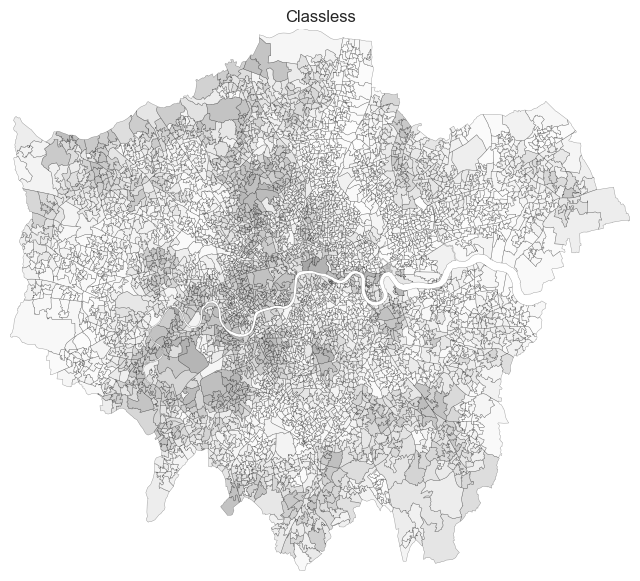

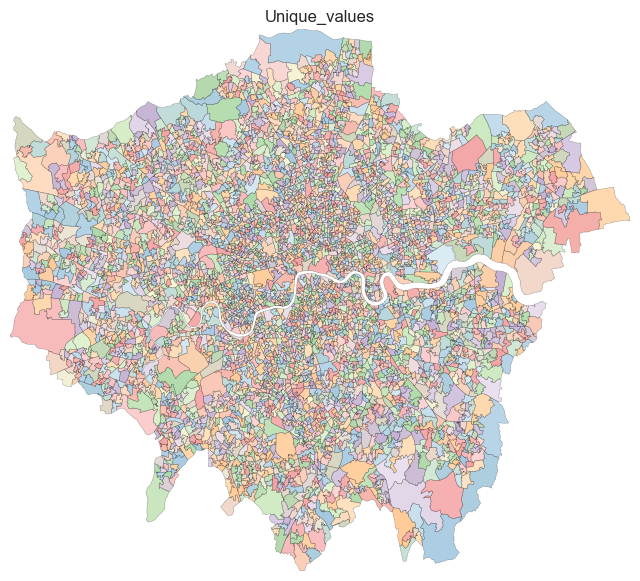

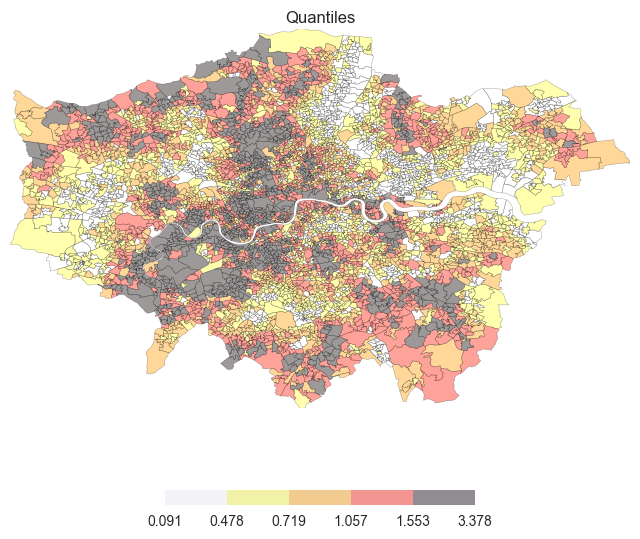

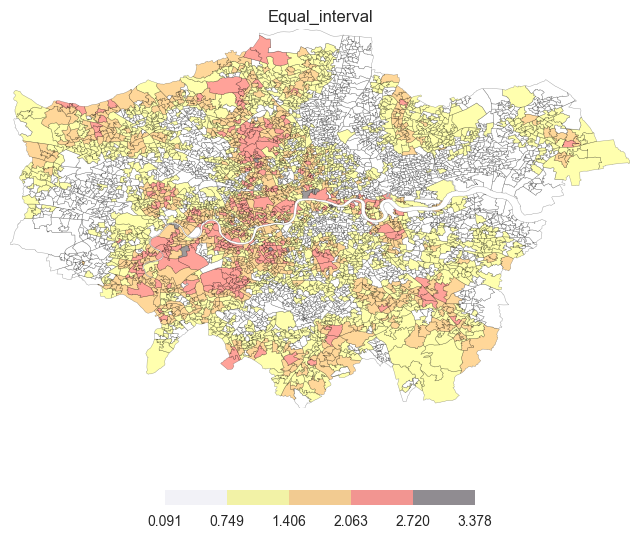

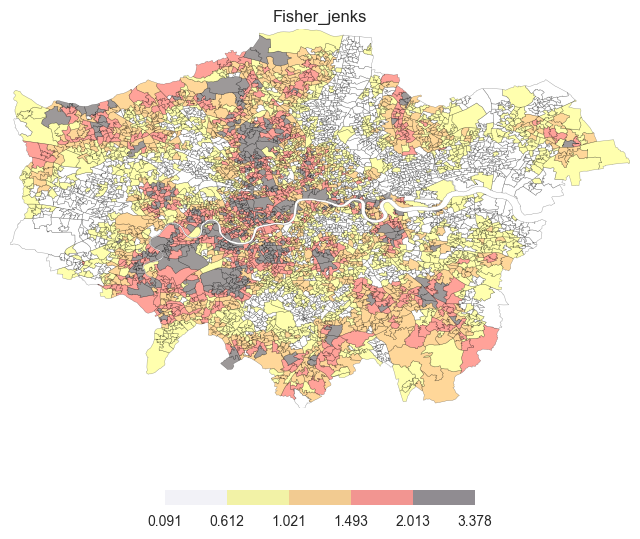

In [9]:
shpdf['Group1Lq'] = (
    shpdf.Group1.values / shpdf.Total.astype(float).values) / (float(shpdf.Group1.sum()) / shpdf.Total.sum()
)

shp_link = os.path.join('shapes','LDN-LSOAs.shp')
shpdf.to_file(shp_link)
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col('Group1Lq'))

types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title=typ.capitalize(), figsize=(8,7))

## Spatial Joins

Simple spatial joins work much like the non-spatial ones we just looked at above, except that the link is made on the basis of location, not some identifier. This makes it much more likely that we'll have 1-to-Many joins, let me illustrate by _first_ using a non-spatial test. Let's have a look at the distribution of LSOAs by borough... but to do that we'll first need to create a Borough variable from... which column contains Borough information indirectly?

In [10]:
# You might want to investigate what I'm up to with str.replace(...)
lsoas['Borough'] = lsoas.lsoa11nm.str.replace('\d\d\d\w$', '', case=False)
lsoas.groupby('Borough').size()

Borough
Barking and Dagenham       110
Barnet                     211
Bexley                     146
Brent                      173
Bromley                    197
Camden                     133
City of London               6
Croydon                    220
Ealing                     196
Enfield                    183
Greenwich                  151
Hackney                    144
Hammersmith and Fulham     113
Haringey                   145
Harrow                     137
Havering                   150
Hillingdon                 161
Hounslow                   142
Islington                  123
Kensington and Chelsea     103
Kingston upon Thames        98
Lambeth                    178
Lewisham                   169
Merton                     124
Newham                     164
Redbridge                  161
Richmond upon Thames       115
Southwark                  166
Sutton                     121
Tower Hamlets              144
Waltham Forest             144
Wandsworth                 179


In other words, if we plan to do some work at, say, the Borough level then a join against the LSOA data will give us hundreds of matches! Remember that our AirBnB data is more granular than the LSOAs, so we can expect thousands of matches (even allowing for the fact that we have only taken a _subsample_ of the full data set). You will want to have a look at [the documentation](http://geopandas.org/mergingdata.html?highlight=sjoin#spatial-joins).

But before we complete the join, we need to check that the projections match!

In [11]:
print("AirBnB CRS: " + str(sdf.crs))
print("LSOAs CRS: " + str(lsoas.crs))

AirBnB CRS: {'init': 'epsg:27700'}
LSOAs CRS: {u'lon_0': -2, u'k': 0.9996012717, u'datum': u'OSGB36', u'y_0': -100000, u'no_defs': True, u'proj': u'tmerc', u'x_0': 400000, u'units': u'm', 'wktext': True, u'lat_0': 49}


Although a spatial join _should_ work with these since they are actually _essentially_ the same, **you should resolve this apparent mismatch** by reprojecting the LSOAs into the EPSG:27700 format (BNG) and _then_ join.

In [12]:
lsoas = lsoas.to_crs( {'init': 'epsg:27700'} )
airbnb = gpd.sjoin(sdf, lsoas, how="inner", op='within')
print("airbnb has {0} rows, {1} columns".format(airbnb.shape[0], airbnb.shape[1]))
airbnb.sample(3)[['id','name','neighbourhood','lsoa11nm','Borough']] # Remember Borough is from the LSOA Name

airbnb has 4932 rows, 104 columns


,id,name,neighbourhood,lsoa11nm,Borough
24339,1354206,Chiswick: 2 bedroom Garden Flat,Acton,Hounslow 029A,Hounslow
25622,13017215,"Raj ,lives in London since 16years.",NaN,Harrow 019A,Harrow
27677,13798697,"Central London Swiss Cottage, St Johns Wood",St. John's Wood,Westminster 002A,Westminster


While that might look promising, there could be trouble lurking... it will help if we ensure that we're comparing like to like by removing any leading or trailing whitespace from neighbourhood and Borough names:

In [14]:
# Tidy up the two strings so that they're more likely to match
airbnb['neighbourhood'] = airbnb.neighbourhood.str.strip()
airbnb['Borough'] = airbnb.Borough.str.strip()
# Are there any non-matching rows?
airbnb[ (airbnb.neighbourhood.str.strip() != airbnb.Borough.str.strip()) & (airbnb.neighbourhood.notnull()) ][
    ['id','name','neighbourhood','Borough']]

,id,name,neighbourhood,Borough
46958,9306445,1 Bedroom Apartment Near the Tube,LB of Barking and Dagenham,Barking and Dagenham
15320,9693543,2 bed House with Garden for family,LB of Barking and Dagenham,Barking and Dagenham
26069,696080,The Becontree House,LB of Barking and Dagenham,Barking and Dagenham
41189,13377140,3 bedroons house,LB of Barking and Dagenham,Barking and Dagenham
25627,5359257,Barking Guesthouse Triple Room,LB of Barking and Dagenham,Barking and Dagenham
10423,13852717,"Clean, comfortable double bedroom in quiet semi.",LB of Barking and Dagenham,Barking and Dagenham
25757,11737882,Spacious One Bedroom Flat,LB of Barking and Dagenham,Barking and Dagenham
4033,13743579,"Stunning Kingsize Room in Chadwell Heath, Dage...",LB of Barking and Dagenham,Barking and Dagenham
24356,14230859,"Double room, cosy house, fast central connections",LB of Barnet,Barnet
33569,14964241,Large Double Room in quiet North West London H...,LB of Barnet,Barnet


My sample included a number of 'LB of' and 'RB of' (London Borough of... and Royal Borough of...) that would also need to be stripped out in order to improve our matching of neighbourhoods:

In [15]:
# Strip out 'LB of' and 'RB of'
airbnb['neighbourhood'] = airbnb.neighbourhood.str.replace('LB of ','').str.replace('RB of','')

# And repeat
airbnb[ (airbnb.neighbourhood.str.strip() != airbnb.Borough.str.strip()) & (airbnb.neighbourhood.notnull()) ].groupby(['Borough','neighbourhood']).size()

Borough      neighbourhood      
Barnet       Hampstead               1
             Haringey                1
Brent        City of Westminster     1
Bromley      Crystal Palace          4
             Sydenham                1
Camden       Bloomsbury             11
             Camden Town            15
             Clerkenwell             7
             Covent Garden          13
             Fitzrovia               7
             Hampstead              87
             Holborn                 5
             Kings Cross             4
             Primrose Hill           5
             Somers Town            16
             St. Pancras            21
             Westminster             1
Croydon      Crystal Palace          4
Ealing       Acton                  27
             Hillingdon              1
Greenwich    Deptford                1
Hackney      Dalston                30
             De Beauvoir Town       23
             Haggerston             22
             Haringey          

So... notice that there are some mismatches between neighbourhood and borough: in some cases this is because the neighbourhood value is at a higher resolution (_e.g._ Shoreditch is within Hackney) but it also looks like some properties are being 'upgraded' from one borough to another (_e.g._ Tower Hamlets to Hackney). In the full data set we might be able to evaluate the extent of this issue... 

**_Note:_** as an alternative to `dropna()` we can all do `fillna()` when slicing through a data frame to extract rows using a column that contains NaNs.

In [16]:
# Note: this is the full data set
kendf = df[ df.name.str.contains('Kensington').fillna(False) ]
print("kendf has {0} rows, {1} columns".format(kendf.shape[0], kendf.shape[1]))

# Fix the price data
kendf['price'] = kendf.loc[:,('price')].str.replace("$",'').str.replace(",",'').astype(float)

# Show what we've got
kendf.groupby('neighbourhood').size()

kendf has 824 rows, 95 columns


/Applications/anaconda/envs/spats/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


neighbourhood
Bayswater                         6
Chelsea                           8
Earls Court                     161
Fulham                            3
Hammersmith                     159
Holland Park                     63
Kensington                      138
Knightsbridge                     8
LB of Barnet                      2
Notting Hill                      6
Pimlico                           1
RB of Kensington and Chelsea     12
Sands End                         1
Shepherd's Bush                   2
dtype: int64

## Over To You: Testing Neighbourhood Listings

Well _that's_ interesting, let's explore! Pulling together the code you've used above (_and_ extending some of the ideas) try mapping out the AirBnB listings that sell themselves as being in Kensington and seeing if there is some kind of persistent bias. I should point out that, technically, they simply mention Kensington and so might be fairly honest in saying 'we are near Kensington...'

Your map should focus on the area around Kensington & Chelsea, and not show all of London. This will require to work out how to make use of the bounding boxes to clip your data, or to create a subset of your data so that it's easy to clip to the range of the AirBnB listings...

**_Remember_**: if you reall want to check that you've successfully written your own script then you should be able to _Restart_ the Kernel (from the drop-down) and then run _only_ the code block below in order to produce your analysis.

Kensington listings geodata frame created...
Kensington borough geodata frame created...
Shapefiles written.
[522900, 176800, 529500, 190400]
There are 824 rows in the listings DBF.
                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=   75.000               177
  75.000 < x[i] <=  100.000               167
 100.000 < x[i] <=  130.000               152
 130.000 < x[i] <=  185.000               167
 185.000 < x[i] <= 2466.000               161


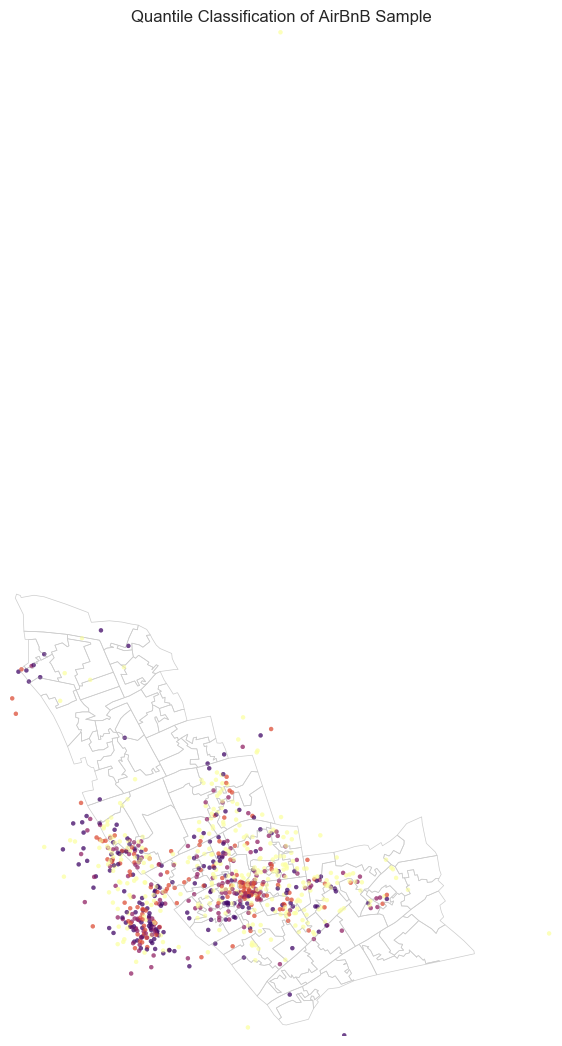

Done.


In [17]:
# Create a geodata frame from the Kensington data frame
geometry = [Point(xy) for xy in zip(kendf.longitude, kendf.latitude)]
crs      = {'init': 'epsg:4326'} # What projection is lat/long?
ken_sdf  = gpd.GeoDataFrame(kendf, crs=crs, geometry=geometry)
ken_sdf  = ken_sdf.to_crs({'init': 'epsg:27700'}) # Reproject into OSGB
#ken_sdf.sample(3)
print("Kensington listings geodata frame created...")

# Extract the Kensington LSOAs
borough_sdf = lsoas[lsoas.Borough.str.contains('Kensington')]
#borough_sdf.sample(3)
print("Kensington borough geodata frame created...")

# Create the output dir if it doesn't exist
if os.path.isdir('output') is not True:
    print("Creating 'output' directory...")
    os.mkdir('output')

borough_sdf.to_file(os.path.join('output','Kensington.shp'))
ken_sdf.to_file(os.path.join('output','KensingtonListings.shp'))
print("Shapefiles written.")

import math
my_bbox = list(ken_sdf.total_bounds)
my_bbox[0] = int(math.floor(my_bbox[0] / 100.0)) * 100
my_bbox[1] = int(math.floor(my_bbox[1] / 100.0)) * 100
my_bbox[2] = int(math.ceil(my_bbox[2] / 100.0)) * 100
my_bbox[3] = int(math.ceil(my_bbox[3] / 100.0)) * 100
print(my_bbox)

from pylab import *

the_borough = ps.open(os.path.join('output','Kensington.shp'))
listings = ps.open(os.path.join('output','KensingtonListings.shp'))

listingsdata = ps.open(os.path.join('output','KensingtonListings.dbf'))
print("There are " + str(len(listingsdata)) + " rows in the listings DBF.")

prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data
pricesq5 = ps.esda.mapclassify.Quantiles(prices, k=5) # Classify into 5 quantiles
print(pricesq5) # Show the classification result

fig = figure(figsize=(7,13)) # Why do you think I changed the figure size this way?

base = maps.map_poly_shp(the_borough)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, pricesq5.yb, cmap='inferno')
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(10, len(listingsdata))) # Sice of the dots

plt.title("Quantile Classification of AirBnB Sample")
ax = maps.setup_ax([base, lyr], [my_bbox, my_bbox]) # You should get a 'crop' of London
fig.add_axes(ax)
show() # There is one right under the 'o' of Classification
       # You will need to scroll down to the map!
print("Done.")